In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rpy2
%load_ext rpy2.ipython

In [4]:
%%R
# Colormapping of geom_hex is bugged on release version of ggplot2 at 2023-01-05.
# This bug is fixed in the development version.
# See also https://stackoverflow.com/a/75004245
devtools::install_github("tidyverse/ggplot2")

R[write to console]: Skipping install of 'ggplot2' from a github remote, the SHA1 (d85eb625) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
%%R
library(tidyverse)
library(ggplot2)
library(ggh4x)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0.9000     ✔ purrr   0.3.5     
✔ tibble  3.1.8          ✔ dplyr   1.0.10    
✔ tidyr   1.2.1          ✔ stringr 1.5.0     
✔ readr   2.1.3          ✔ forcats 0.5.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
date_of_processing = "2023-01-05"

In [4]:
def relabel(df):
    # Relabeling
    # - Approach
    df["approach"] = "GA"
    df.loc[df["algorithm_type"].str.contains("ecga"), "approach"] = "ECGA"
    df.loc[df["algorithm_type"].str.contains("gomea"), "approach"] = "GOMEA"
    df["approach"] = pd.Categorical(df["approach"], categories=["GOMEA", "ECGA", "GA"], ordered=True)
    # - selection
    df["selection"] = "-"
    df.loc[df["replacement_strategy"] == 5, "selection"] = "steady-state"
    df.loc[df["replacement_strategy"] == 6, "selection"] = "generational"
    df["selection"] = pd.Categorical(df["selection"], categories=["-", "steady-state", "generational"], ordered=True)
    # - CX
    df["cx"] = "-"
    df.loc[df["algorithm_type"].str.contains("subfunction"), "cx"] = "SFX"
    df.loc[df["algorithm_type"].str.contains("uniform"), "cx"] = "UX"
    df.loc[df["algorithm_type"].str.contains("twopoint"), "cx"] = "TPX"
    df["cx"] = pd.Categorical(df["cx"], categories=["-", "UX", "TPX", "SFX"], ordered=True)
    # - (a)sync 
    df["(a)sync"] = "s"
    df.loc[df["algorithm_type"].str.contains("async"), "(a)sync"] = "a"
    df["(a)sync"] = pd.Categorical(df["(a)sync"], categories=["a", "s"], ordered=True)
    # - timing distribution - not saved for these plots
    # df["timing"] = pd.Categorical(df["runtime_type"].replace({
    #     "cheap-ones-100": "100:1",
    #     "cheap-ones-10": "10:1",
    #     "cheap-ones": "2:1",
    #     "constant": "1:1",
    #     "expensive-ones": "1:2",
    #     "expensive-ones-10": "1:10",
    #     "expensive-ones-100": "1:100",
    # }), categories = ["100:1", "10:1", "2:1", "1:1", "1:2", "1:10", "1:100"], ordered=True)

In [5]:
evaluations = pd.read_csv("./results/2022-11-16-nasbench-evaluations.csv.gz")

remapping_algorithm_type = {
    "sync": "ecga-sync",
    "async-throttled": "ecga-async-th",
}
evaluations["algorithm_type"] = evaluations["algorithm_type"].replace(remapping_algorithm_type)

relabel(evaluations)

evaluations

,Unnamed: 0,#evaluations,simulation time (s),objectives,time_spent,genotype (categorical),problem,seed,vtr,replacement_strategy,tournament_size,algorithm_type,population_size_chosen,num_processors,population_size,approach,selection,cx,(a)sync
0,0,1,0.000000,-93.8638,4645.923107,4 2 0 3 1 5 6 1 1 9 6 3 1 5 2 3 4 5 3 5 1 1 1 ...,nasbench301,51,95.2726,5,8,ecga-sync,1984,1984,NaN,ECGA,steady-state,-,s
1,1,2,0.000000,-93.4862,4988.136382,2 1 3 5 0 2 7 1 4 0 3 0 4 1 4 0 4 4 5 4 6 3 2 ...,nasbench301,51,95.2726,5,8,ecga-sync,1984,1984,NaN,ECGA,steady-state,-,s
2,2,3,0.000000,-92.4785,3885.660152,2 4 6 5 0 5 4 2 1 9 5 0 0 6 5 0 5 6 1 0 1 1 6 ...,nasbench301,51,95.2726,5,8,ecga-sync,1984,1984,NaN,ECGA,steady-state,-,s
3,3,4,0.000000,-92.5263,3891.022711,1 2 5 5 2 5 1 2 1 6 4 0 0 2 1 1 4 2 1 3 2 6 0 ...,nasbench301,51,95.2726,5,8,ecga-sync,1984,1984,NaN,ECGA,steady-state,-,s
4,4,5,0.000000,-93.2953,4704.903596,5 4 4 4 2 0 6 2 3 2 2 0 0 0 4 0 3 0 3 2 4 5 3 ...,nasbench301,51,95.2726,5,8,ecga-sync,1984,1984,NaN,ECGA,steady-state,-,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503423,115458,115460,157618.682463,-95.1941,6040.645920,2 2 0 3 2 1 1 0 0 0 4 3 2 6 4 3 4 3 4 4 4 3 4 ...,nasbench301,51,95.2726,6,4,ecga-async-th,4096,4096,4096.0,ECGA,generational,-,a
1503424,115459,115461,157618.850125,-95.2014,6157.628684,2 2 0 4 2 1 1 0 0 0 4 4 2 4 4 3 4 3 4 4 4 3 4 ...,nasbench301,51,95.2726,6,4,ecga-async-th,4096,4096,4096.0,ECGA,generational,-,a
1503425,115460,115462,157619.500735,-95.2163,6092.778145,2 2 0 4 2 1 1 0 4 0 4 4 2 0 4 3 4 3 4 3 4 3 4 ...,nasbench301,51,95.2726,6,4,ecga-async-th,4096,4096,4096.0,ECGA,generational,-,a
1503426,115461,115463,157620.760299,-95.1710,6133.019082,2 2 0 4 0 1 1 0 0 0 6 4 2 5 4 3 1 3 4 4 4 3 4 ...,nasbench301,51,95.2726,6,4,ecga-async-th,4096,4096,4096.0,ECGA,generational,-,a


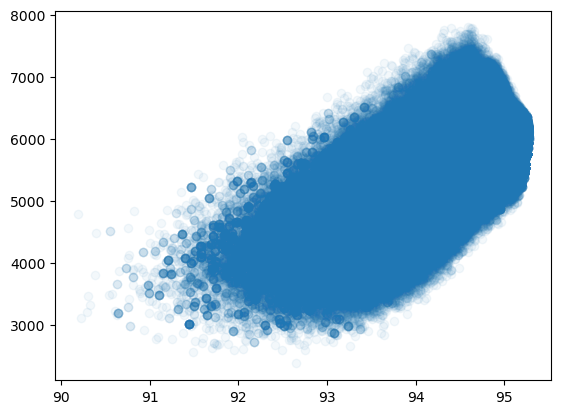

In [8]:
plt.scatter(-evaluations["objectives"], evaluations["time_spent"], color=None, alpha=0.05)

In [8]:
%R -i evaluations

Saving 4.86 x 2.78 in image


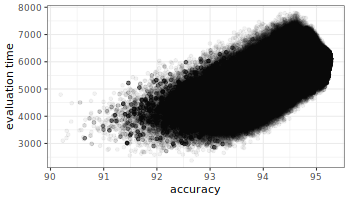

In [20]:
%%R -i date_of_processing -w 350 -h 200

plt <- evaluations |>
    mutate(
      accuracy = -`objectives`,
      "evaluation time" = `time_spent`
    ) |>
    ggplot(aes(x=`accuracy`, y=`evaluation time`)) +
    geom_point(alpha=0.05) + 
    theme_bw()

# Do not save as pdf - every point is plotted individually leading to a 40MB figure.
# fpath = paste(date_of_processing, "-scatter-nasbench.pdf", sep="")
# ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-scatter-nasbench.png", sep="")
ggsave(fpath, type = "cairo", dpi=500)
plt

Saving 4.86 x 2.78 in image
Saving 4.86 x 2.78 in image


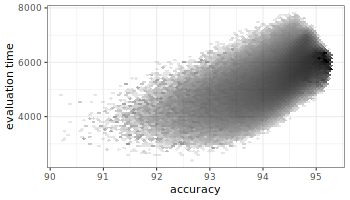

In [63]:
%%R -i date_of_processing -w 350 -h 200
# Note: geom_hex is bugged in the release version of ggplot on 2023-01-05, as stated on top of this notebook.
# Ensure the development version is installed, containing the bugfix.
plt <- evaluations |>
    mutate(
      accuracy = -`objectives`,
      "evaluation time" = `time_spent`
    ) |>
    ggplot(aes(x=`accuracy`, y=`evaluation time`)) +
    geom_hex(aes(color=NULL, alpha=..density..), fill='black', color='transparent', bins=70) +
    scale_fill_continuous(trans="log10") +
    scale_alpha_continuous(trans="log10", guide = "none") +
    theme_bw()

fpath = paste(date_of_processing, "-hexdensity-nasbench.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-hexdensity-nasbench.png", sep="")
ggsave(fpath, type = "cairo", dpi=500)
plt

Saving 13.9 x 2.78 in image
Saving 13.9 x 2.78 in image


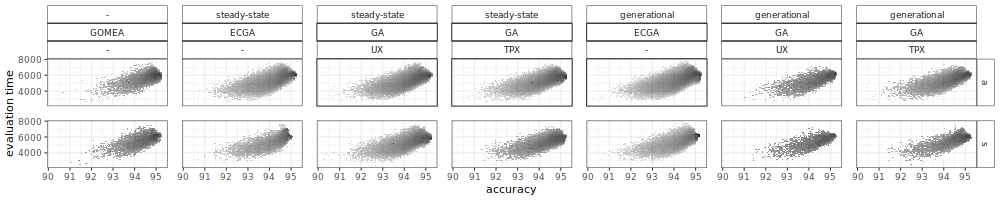

In [58]:
%%R -i date_of_processing -w 1000 -h 200
# Note: geom_hex is bugged in the release version of ggplot on 2023-01-05, as stated on top of this notebook.
# Ensure the development version is installed, containing the bugfix.
plt <- evaluations |>
    mutate(
      accuracy = -`objectives`,
      "evaluation time" = `time_spent`,
    ) |>
    ggplot(aes(x=`accuracy`, y=`evaluation time`)) +
    geom_hex(aes(color=NULL, alpha=..density..), fill='black', bins=70) +
    scale_fill_continuous(trans="log10") +
    scale_alpha_continuous(trans="log10", guide = "none") +
    facet_grid(`(a)sync` ~ `selection` + `approach` + `cx`) +
    theme_bw() +
    theme(
      legend.position = "none",
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_rect(fill='transparent'),
      # strip.text.x = element_text(size = 11)
      )

fpath = paste(date_of_processing, "-hexdensity-per-approach-nasbench.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-hexdensity-per-approach-nasbench.png", sep="")
ggsave(fpath, type = "cairo", dpi=500)
plt

Saving 13.9 x 2.78 in image
Saving 13.9 x 2.78 in image


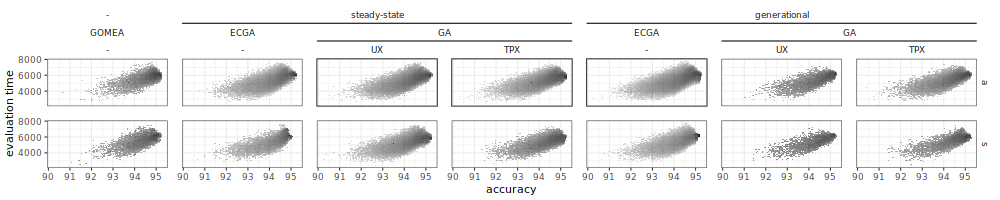

In [13]:
%%R -i date_of_processing -w 1000 -h 200
# Note: geom_hex is bugged in the release version of ggplot on 2023-01-05, as stated on top of this notebook.
# Ensure the development version is installed, containing the bugfix.
# This one uses facet nested
plt <- evaluations |>
    mutate(
      accuracy = -`objectives`,
      "evaluation time" = `time_spent`,
    ) |>
    ggplot(aes(x=`accuracy`, y=`evaluation time`)) +
    geom_hex(aes(color=NULL, alpha=..density..), fill='black', bins=70) +
    scale_fill_continuous(trans="log10") +
    scale_alpha_continuous(trans="log10", guide = "none") +
    facet_nested(`(a)sync` ~ `selection` + `approach` + `cx`, nest_line = element_line()) +
    theme_bw() +
    theme(
      legend.position = "none",
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
      # strip.background = element_rect(fill='transparent'),
      # strip.text.x = element_text(size = 11)
      )

fpath = paste(date_of_processing, "-hexdensity-per-approach-nasbench.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-hexdensity-per-approach-nasbench.png", sep="")
ggsave(fpath, type = "cairo", dpi=500)
plt

Saving 13.9 x 2.78 in image


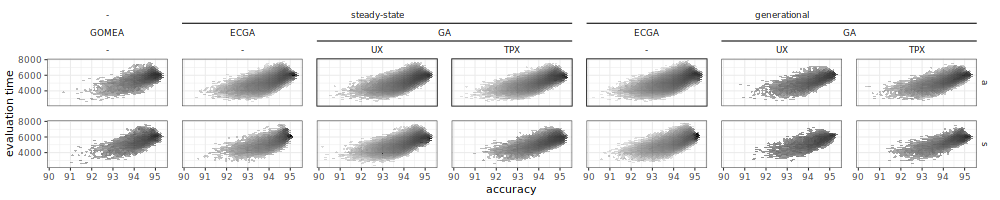

In [14]:
%%R -i date_of_processing -w 1000 -h 200
# Note: geom_hex is bugged in the release version of ggplot on 2023-01-05, as stated on top of this notebook.
# Ensure the development version is installed, containing the bugfix.
# This one uses facet nested
plt <- evaluations |>
    mutate(
      accuracy = -`objectives`,
      "evaluation time" = `time_spent`,
    ) |>
    ggplot(aes(x=`accuracy`, y=`evaluation time`)) +
    geom_hex(aes(color=NULL, alpha=..density..), fill='black', bins=35) +
    scale_fill_continuous(trans="log10") +
    scale_alpha_continuous(trans="log10", guide = "none") +
    facet_nested(`(a)sync` ~ `selection` + `approach` + `cx`, nest_line = element_line()) +
    theme_bw() +
    theme(
      legend.position = "none",
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
      # strip.background = element_rect(fill='transparent'),
      # strip.text.x = element_text(size = 11)
      )

fpath = paste(date_of_processing, "-hexdensity-per-approach-nasbench-lr.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
# fpath = paste(date_of_processing, "-hexdensity-per-approach-nasbench-lr.png", sep="")
# ggsave(fpath, type = "cairo", dpi=500)
plt

Saving 4.86 x 2.78 in image
Saving 4.86 x 2.78 in image


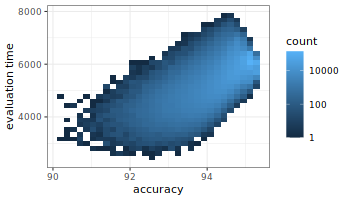

In [29]:
%%R -i date_of_processing -w 350 -h 200

plt <- evaluations |>
    mutate(
      accuracy = -`objectives`,
      "evaluation time" = `time_spent`
    ) |>
    ggplot(aes(x=`accuracy`, y=`evaluation time`)) +
    geom_bin_2d() +
    scale_fill_continuous(trans="log10") +
    theme_bw()

# Do not save as pdf - every point is plotted individually leading to a 40MB figure.
fpath = paste(date_of_processing, "-density-nasbench.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-density-nasbench.png", sep="")
ggsave(fpath, type = "cairo", dpi=500)
plt

In [132]:
evaluations_gomea_a = evaluations[(evaluations["approach"] == "GOMEA") & (evaluations["(a)sync"] == "a")]
evaluations_gomea_a = evaluations_gomea_a[(evaluations_gomea_a["population_size"] == evaluations_gomea_a.iloc[0]["population_size"])]
evaluations_gomea_a

,Unnamed: 0,#evaluations,simulation time (s),objectives,time_spent,genotype (categorical),problem,seed,vtr,replacement_strategy,tournament_size,algorithm_type,population_size_chosen,num_processors,population_size,approach,selection,cx,(a)sync
185008,0,1,0.000000e+00,-93.8638,4645.923107,4 2 0 3 1 5 6 1 1 9 6 3 1 5 2 3 4 5 3 5 1 1 1 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
185009,1,2,0.000000e+00,-93.4862,4988.136382,2 1 3 5 0 2 7 1 4 0 3 0 4 1 4 0 4 4 5 4 6 3 2 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
185010,2,3,0.000000e+00,-92.4785,3885.660152,2 4 6 5 0 5 4 2 1 9 5 0 0 6 5 0 5 6 1 0 1 1 6 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
185011,3,4,0.000000e+00,-92.5263,3891.022711,1 2 5 5 2 5 1 2 1 6 4 0 0 2 1 1 4 2 1 3 2 6 0 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
185012,4,5,0.000000e+00,-93.2953,4704.903596,5 4 4 4 2 0 6 2 3 2 2 0 0 0 4 0 3 0 3 2 4 5 3 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200336,15328,15330,1.567673e+06,-94.9984,6205.206243,2 2 0 2 0 1 4 0 3 6 3 4 6 5 3 3 3 4 2 4 1 3 4 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
200337,15329,15331,1.567719e+06,-94.9650,6080.438715,2 3 4 3 0 3 4 0 2 6 2 4 3 3 3 3 4 4 4 4 5 3 4 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
200338,15330,15332,1.567749e+06,-95.0108,6169.897561,2 2 1 4 0 3 4 2 0 1 4 4 6 3 3 3 0 1 4 4 1 1 3 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a
200339,15331,15333,1.567821e+06,-95.0671,6021.562889,2 2 3 4 1 1 3 0 0 0 3 5 0 3 3 3 4 4 4 3 3 3 4 ...,nasbench301,51,95.2726,0,4,gomea-async,56,64,56.0,GOMEA,-,-,a


In [133]:
evaluations_gomea_s = evaluations[(evaluations["approach"] == "GOMEA") & (evaluations["(a)sync"] == "s")]
evaluations_gomea_s = evaluations_gomea_s[(evaluations_gomea_s["population_size"] == evaluations_gomea_s.iloc[0]["population_size"])]
evaluations_gomea_s

,Unnamed: 0,#evaluations,simulation time (s),objectives,time_spent,genotype (categorical),problem,seed,vtr,replacement_strategy,tournament_size,algorithm_type,population_size_chosen,num_processors,population_size,approach,selection,cx,(a)sync
765833,0,1,0.000000e+00,-93.8638,4645.923107,4 2 0 3 1 5 6 1 1 9 6 3 1 5 2 3 4 5 3 5 1 1 1 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
765834,1,2,0.000000e+00,-93.4862,4988.136382,2 1 3 5 0 2 7 1 4 0 3 0 4 1 4 0 4 4 5 4 6 3 2 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
765835,2,3,0.000000e+00,-92.4785,3885.660152,2 4 6 5 0 5 4 2 1 9 5 0 0 6 5 0 5 6 1 0 1 1 6 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
765836,3,4,0.000000e+00,-92.5263,3891.022711,1 2 5 5 2 5 1 2 1 6 4 0 0 2 1 1 4 2 1 3 2 6 0 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
765837,4,5,0.000000e+00,-93.2953,4704.903596,5 4 4 4 2 0 6 2 3 2 2 0 0 0 4 0 3 0 3 2 4 5 3 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779753,13920,13922,1.484465e+06,-94.9495,5548.568141,3 2 0 4 0 2 4 1 3 6 3 4 4 0 2 2 4 3 4 3 3 5 4 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
779754,13921,13923,1.484618e+06,-95.1426,6165.273230,2 2 4 4 1 3 4 0 0 0 3 4 1 6 3 2 3 2 4 4 4 3 4 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
779755,13922,13924,1.484715e+06,-94.9829,6396.353466,4 3 4 0 0 2 2 0 0 2 6 3 4 6 2 2 6 4 4 3 4 3 4 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s
779756,13923,13925,1.484775e+06,-95.0372,6187.789627,2 3 0 4 0 4 1 1 0 0 3 3 4 5 2 3 4 4 4 4 4 3 4 ...,nasbench301,51,95.2726,0,4,gomea-sync,60,60,60.0,GOMEA,-,-,s


In [137]:
def process_run(es_run, tag):
    # Determine processor assignments (i.e. isolate GOM runs)
    new_evals = pd.DataFrame({
        "ord": es_run["Unnamed: 0"],
        "t": (es_run["simulation time (s)"]).round(2),
        "kind": "new",
    })
    complete_evals = pd.DataFrame({
        "ord": es_run["Unnamed: 0"],
        "t": (es_run["simulation time (s)"] + es_run["time_spent"]).round(2),
        "kind": "complete",
    })
    df = pd.concat([new_evals, complete_evals]).sort_values(["t", "kind", "ord"]).reset_index()
    df["kind"] = pd.Categorical(df["kind"], ["complete", "new"], ordered=True)

    def determine_procs(df, max_procs = None):
        procs = []
        nprocs = 0
        def get_proc():
            nonlocal procs, nprocs
            if len(procs) > 0:
                return procs.pop()
            else:
                nprocs += 1
                return nprocs - 1
        ord_to_proc = {}
        df["proc"] = None
        for (idx, l) in df.iterrows():
            if l["kind"] == "new":
                p = get_proc()
                if max_procs and nprocs > max_procs:
                    raise RuntimeError(f"More procs used than available at idx {idx} - line {l}")
                df.loc[idx, "proc"] = p
                ord_to_proc[l["ord"]] = p
            else:
                p = ord_to_proc[l["ord"]]
                procs.append(p)

    determine_procs(df, max_procs=es_run.iloc[0]["population_size"])

    es_run_procs = pd.merge(es_run, df.loc[df["kind"] == "new", ["ord", "proc"]], left_on="Unnamed: 0", right_on="ord")
    es_run_procs["proc_idx"] = es_run_procs.groupby("proc").cumcount()
    es_run_procs["tag"] = tag

    return es_run_procs[["objectives", "time_spent", "simulation time (s)", "#evaluations", "proc", "proc_idx", "tag"]]


In [ ]:
egom = process_run(evaluations_gomea_a, tag="asynchronous")

In [ ]:
egom = process_run(evaluations_gomea_a, tag="synchronous")

In [138]:
runs = pd.concat([
    process_run(evaluations_gomea_a, tag="asynchronous"),
    process_run(evaluations_gomea_s, tag="synchronous"),
])

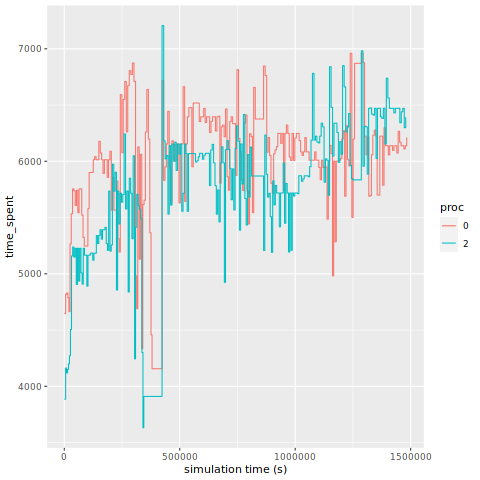

In [121]:
%%R -i egom
egom |>
    filter(`proc` %in% c(0, 2)) |>
    mutate("proc" = factor(proc)) |>
    ggplot(aes(x=`simulation time (s)`, y=`time_spent`, color=`proc`)) +
    scale_color_discrete() +
    geom_step()

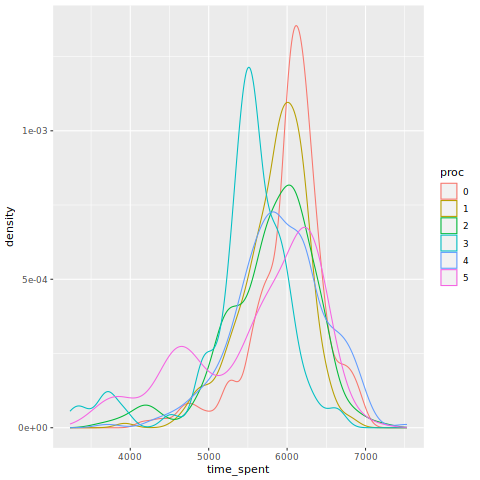

In [122]:
%%R -i egom
egom |>
    filter(`proc` %in% c(0, 1, 2, 3, 4, 5)) |>
    mutate("proc" = factor(proc)) |>
    ggplot(aes(x=`time_spent`, group=`proc`, color=`proc`)) +
    geom_density(aes(y=..density..), fill="transparent", bins=30)

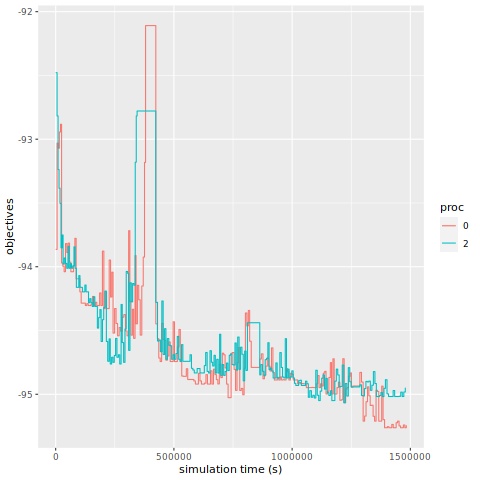

In [123]:
%%R -i egom
egom |>
    filter(`proc` %in% c(0, 2)) |>
    mutate("proc" = factor(proc)) |>
    ggplot(aes(x=`simulation time (s)`, y=`objectives`, color=`proc`)) +
    scale_color_discrete() +
    geom_step()

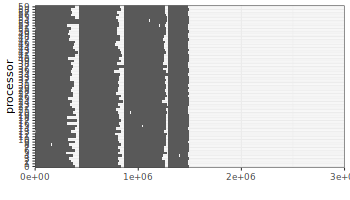

In [131]:
%%R -i egom -i date_of_processing -w 350 -h 200
barheight = 1.0
maxprocs = max(egom$proc)
plt <- egom |>
    mutate(
        t_start = `simulation time (s)`,
        t_end = `simulation time (s)` + `time_spent`,
        ymin = `proc` - barheight / 2,
        ymax = `proc` + barheight / 2
    ) |> 
    ggplot(aes(xmin=`t_start`, xmax=`t_end`, ymin=`ymin`, ymax=`ymax`), color='black') +
    geom_rect() +
    coord_cartesian(xlim = c(0, 3000000)) +
    scale_x_continuous(expand=c(0.0, 0.0)) +
    scale_y_continuous(breaks=seq.int(0, maxprocs), expand=c((1-barheight)/maxprocs, (1-barheight)/maxprocs)) +
    guides(fill = NULL) +
    theme_bw() +
    theme(
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
      strip.text.x = element_text(size = 11)) +
    labs(x="", y="processor")

# fpath = paste(date_of_processing, "-sync-vs-async.pdf", sep="")
# ggsave(fpath, device = cairo_pdf)
# fpath = paste(date_of_processing, "-sync-vs-async.png", sep="")
# ggsave(fpath, type = "cairo")

plt

Saving 4.86 x 2.78 in image
Saving 4.86 x 2.78 in image


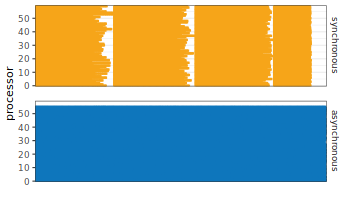

In [165]:
%%R -i runs -i date_of_processing -w 350 -h 200
barheight = 1.0
maxprocs = max(runs$proc)
plt <- runs |>
    mutate(
        t_start = `simulation time (s)`,
        t_end = `simulation time (s)` + `time_spent`,
        tag = factor(`tag`, levels=c('synchronous', 'asynchronous')),
        ymin = `proc` - barheight / 2,
        ymax = `proc` + barheight / 2
    ) |> 
    ggplot(aes(xmin=`t_start`, xmax=`t_end`, ymin=`ymin`, ymax=`ymax`, fill=`tag`)) + #, color='black'
    geom_rect(aes(color=`tag`)) + #
    scale_fill_manual(values=c("synchronous"="#f6a519", "asynchronous"="#0e76bc")) +
    scale_color_manual(values=c("synchronous"="#f6a519", "asynchronous"="#0e76bc")) +
    # scale_color_manual(values=c("synchronous"="#c48414", "asynchronous"="#095487")) +
    # coord_cartesian(xlim = c(0, 130)) +
    scale_x_continuous(breaks=NULL, expand=c(0.0, 0.0)) +
    scale_y_continuous(expand=c((1-barheight)/maxprocs, (1-barheight)/maxprocs)) +
    # scale_y_continuous(breaks=seq.int(0, maxprocs), expand=c((1-barheight)/maxprocs, (1-barheight)/maxprocs)) +
    facet_grid(tag ~ .) +
    guides(fill = NULL) +
    theme_bw() +
    theme(
      legend.position = "none",
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
      strip.text.x = element_text(size = 11)) +
    labs(x="", y="processor")

fpath = paste(date_of_processing, "-gomea-sync-vs-async-nasbench.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-gomea-sync-vs-async-nasbench.png", sep="")
ggsave(fpath, type = "cairo")

plt

In [162]:
runs_x = runs.copy()
runs_x["t_start"] = runs_x["simulation time (s)"]
runs_x["t_end"] = runs_x["simulation time (s)"] + runs_x["time_spent"]
runs_g = runs_x.sort_values(["tag", "proc", "t_start"])
runs_g["t_wasted"] = runs_g["t_start"] - np.where(runs_g["proc"] == runs_g["proc"].shift(1), runs_g["t_end"].shift(1), 0)
runs_g.groupby(["tag", "proc"])["t_wasted"].sum().groupby(["tag"]).mean()

tag
asynchronous         0.000002
synchronous     140059.059379
Name: t_wasted, dtype: float64

In [164]:
140059.059379 / 6000

23.34317656316667

In [ ]:
runs_g